<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch5_%EC%98%88%EC%A0%9C_02_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter5-3. RNN Example
## [예제2] Stock Prediction

## Mount Drive 
> ### 아래 코드를 실행하고 인증과정 수행

In [1]:
from google.colab import drive
drive.mount('/content/drive') # 나의 드라이브에 마운트 시킨 것!

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## PWD 변경 
> ### data-02-stock_daily.csv 파일이 있는 위치로 이동

In [3]:
# 아래 cd 명령 우측에 'data-02-stock_daily.csv' 파일이 있는 디렉토리의 주소를 기록 후 아래 코드 실행!
# ls 명령의 결과로 'data-02-stock_daily.csv' 파일의 존재여부 확인 후 계속 진행
#/data-02-stock_daily.csv
% cd /content/drive/My Drive/AI_BASIC_TENSORFLOW/Chapter5
% ls

/content/drive/My Drive/AI_BASIC_TENSORFLOW/Chapter5
Ch5_예제_01_Basic_RNN.ipynb         data-02-stock_daily.csv
Ch5_예제_02_Stock_Prediction.ipynb


> ### Load Module

In [4]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))

tf.VariableScope.reuse = tf.AUTO_REUSE

tf.set_random_seed(777)  # reproducibility

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0


> ### MinMaxScaler

In [0]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator/ (denominator + 1e-7)

> ### Load data

In [6]:
xy = np.loadtxt('./data-02-stock_daily.csv', delimiter = ',')
print(type(xy), xy.shape)
xy = xy[::-1] # csv 데이터가 위->아래 순서로 최근->과거로 배치되어 있으므로, 거꾸로 reverse해주는 것!
xy = MinMaxScaler(xy) # like Normalization
x = xy
y = xy[:,[-1]]  # 전체 행에 대해서 가장 마지막 값만! 즉, Close 가격만 가짐
print("Shape of X is %s" % (x.shape,))  # Open, High, Low, Volume, Close
print("Shape of Y is %s" % (y.shape,))  # Close

<class 'numpy.ndarray'> (732, 5)
Shape of X is (732, 5)
Shape of Y is (732, 1)


> ### Training Data 준비

In [0]:
timesteps = seq_length = 7
data_dim = 5
dataX = []
dataY = []

for i in range(0, len(y)-seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]
    dataX.append(_x)
    dataY.append(_y)

train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
testX = np.array(dataX[train_size:])
testY = np.array(dataY[train_size:])

In [0]:
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

> ### Placeholder

In [0]:
X = tf.placeholder(tf.float32, (None, seq_length, data_dim))  # (?, 7일, 5개 데이터(Open, High, Low, Volume, Close))
Y = tf.placeholder(tf.float32, (None, 1))                     # 결과 비교할 것은 8일 째의 Close 가격만! == 1개

> ### Network, Cost, Optimize

In [13]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden_dim, activation=tf.tanh)  # hidden_dim==10이므로 Hidden Layer에서 결과로 10개가 나옴. Activation Function은 tf.tanh
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # cell = Hidden의 결과, X = input의 placeholder
print("OUTPUT=",outputs)
print(outputs[:,-1].shape)  # 두 번째 dim의 마지막을 가져 오겠다는 것! => (?, 1, 10)
Y_pred = tf.layers.dense(outputs[:, -1], output_dim)  # output data의 두 번째 dim의 마지막, 즉 Close자료들 -> 1개의 결과 ( output_dim == 1 )

cost = tf.reduce_mean(tf.square(Y_pred - Y))  # cost function으로 mean squared error사용! 실수값을 계산하기 위하여!
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)



targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions)))  # root(error^2) : 제곱으로 인한 뻥튀기를 비교적 Linear하도록 조정

OUTPUT= Tensor("rnn_3/transpose_1:0", shape=(?, 7, 10), dtype=float32)
(?, 10)


> ### Training

In [15]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

costs = []
for i in range(iterations):
    _, costval = sess.run((optm, cost), feed_dict = {X: trainX, Y: trainY})
    costs.append(costval)
    if i % 10 == 0:
        print("[%d/%d] costval : %.4f" % (i, iterations, costval))

[0/500] costval : 0.0801
[10/500] costval : 0.0044
[20/500] costval : 0.0031
[30/500] costval : 0.0027
[40/500] costval : 0.0019
[50/500] costval : 0.0017
[60/500] costval : 0.0016
[70/500] costval : 0.0014
[80/500] costval : 0.0013
[90/500] costval : 0.0013
[100/500] costval : 0.0012
[110/500] costval : 0.0012
[120/500] costval : 0.0011
[130/500] costval : 0.0011
[140/500] costval : 0.0011
[150/500] costval : 0.0010
[160/500] costval : 0.0010
[170/500] costval : 0.0010
[180/500] costval : 0.0010
[190/500] costval : 0.0010
[200/500] costval : 0.0010
[210/500] costval : 0.0010
[220/500] costval : 0.0010
[230/500] costval : 0.0010
[240/500] costval : 0.0009
[250/500] costval : 0.0009
[260/500] costval : 0.0009
[270/500] costval : 0.0009
[280/500] costval : 0.0009
[290/500] costval : 0.0009
[300/500] costval : 0.0009
[310/500] costval : 0.0009
[320/500] costval : 0.0009
[330/500] costval : 0.0009
[340/500] costval : 0.0009
[350/500] costval : 0.0009
[360/500] costval : 0.0009
[370/500] co

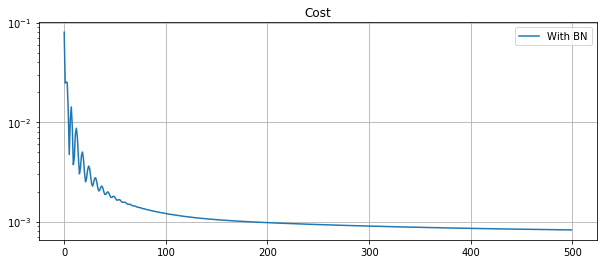

In [16]:
plt.figure(figsize=(10, 4))
plt.semilogy(costs, label='With BN')
plt.grid(True)
plt.legend(loc='best')
plt.title("Cost")
plt.show()

> ### Test

In [17]:
test_predict = sess.run(Y_pred, feed_dict ={X: testX})
rmse = sess.run(rmse, feed_dict = {targets: testY, predictions: test_predict})
print("RMSE = {}".format(rmse))

RMSE = 0.02500324323773384


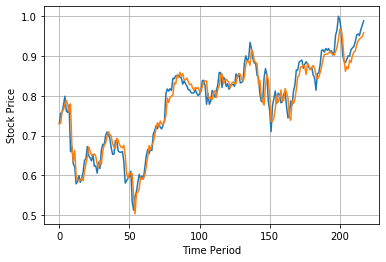

In [18]:
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()  # 파란색: 결과 / 주황색: 예측
            # ==> 내가 예측했던 결과들을 가지고 그것들을 입력 받아 결과치를 예측한 것이 아니라,
            #     그거 무시하고 그 다음 날에는 그 날을 기준으로 7일 전까지의 데이터(실제)를 가지고 만들었다.
            #     그렇기에 정답과 굉장히 유사한 결과를 예측한 것처럼 보이는 것이다!
            #     즉, Test 방법 자체가 잘못됐다고 볼 수 있음! ㅋ RNN(현재의 입력 + 과거의 예측을 통해 미래 예측)으로 했다면, 계속 틀렸고, 그 차이가 더 커졌을 것!
